In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from glob import glob
import re
from skimage.io import imread

import keras

In [2]:
from google.colab import drive
from glob import glob
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Data"
overview = glob(path + '/overview.csv')

In [4]:
overview = pd.read_csv(path + '/overview.csv')

In [5]:
overview.head(100)

,Unnamed: 0,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
0,0,60,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,True,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm
...,...,...,...,...,...,...,...,...
95,95,71,False,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,95,ID_0095_AGE_0071_CONTRAST_0_CT.tif,ID_0095_AGE_0071_CONTRAST_0_CT.dcm
96,96,83,False,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,96,ID_0096_AGE_0083_CONTRAST_0_CT.tif,ID_0096_AGE_0083_CONTRAST_0_CT.dcm
97,97,60,False,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,97,ID_0097_AGE_0060_CONTRAST_0_CT.tif,ID_0097_AGE_0060_CONTRAST_0_CT.dcm
98,98,61,False,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,98,ID_0098_AGE_0061_CONTRAST_0_CT.tif,ID_0098_AGE_0061_CONTRAST_0_CT.dcm


In [6]:
image_list = glob(path + '/tiff_images/*.tif')

In [7]:
imread(image_list[0]).shape

(512, 512)

In [8]:
np.expand_dims(imread(image_list[0])[::4,::4],0).shape

(1, 128, 128)

In [9]:
jimread = lambda x: np.expand_dims(imread(x)[::4,::4],0)

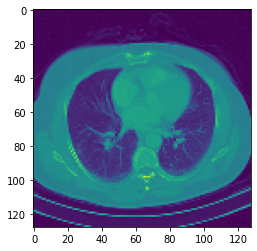

In [10]:
test_image = jimread(image_list[0])
plt.imshow(test_image[0])

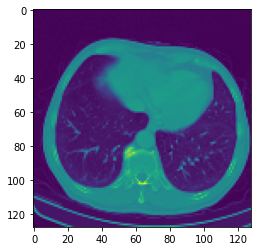

In [11]:
test_image1 = jimread(image_list[1])
plt.imshow(test_image1[0])

In [12]:
test_image[0].shape

(128, 128)

In [13]:
np.array(np.arange(65536)).reshape(256,256)[::4,::4].shape

(64, 64)

In [14]:
np.expand_dims(np.array(np.arange(81)).reshape(9,9)[::4,::4],0).shape

(1, 3, 3)

In [15]:
check_contrast = re.compile(r'/tiff_images/ID_([\d]+)_AGE_[\d]+_CONTRAST_([\d]+)_CT.tif')

In [16]:
label = []
id_list = []
for image in image_list:
    id_list.append(check_contrast.findall(image)[0][0])
    label.append(check_contrast.findall(image)[0][1])

In [17]:
label_list = pd.DataFrame(label,id_list)

In [18]:
count = 0
for i in label_list[0]:
  if i == '1':
    count +=1

count

50

In [19]:
images = np.stack([jimread(i) for i in image_list],0)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(images, label_list, test_size=0.1, random_state=0)

In [22]:
n_train, depth, width, height = X_train.shape
n_test,_,_,_ = X_test.shape

In [23]:
input_shape = (width,height,depth)

In [24]:
input_shape

(128, 128, 1)

In [25]:
input_train = X_train.reshape((n_train, width,height,depth))
input_train.shape
input_train.astype('float32')
input_train = input_train / np.max(input_train)
input_train.max()

1.0

In [26]:
input_test = X_test.reshape(n_test, *input_shape)
input_test.astype('float32')
input_test = input_test / np.max(input_test)

In [27]:
output_train = keras.utils.np_utils.to_categorical(y_train, 2)
output_test = keras.utils.np_utils.to_categorical(y_test, 2)
output_train[5]

array([0., 1.], dtype=float32)

MODEL

In [28]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [29]:
batch_size = 20
epochs = 20

In [30]:
model = Sequential()
model.add(Conv2D(50, 5, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3))) # 3x3 Maxpooling 
model.add(Conv2D(30, 4, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) # 2x2 Maxpooling
model.add(Flatten())
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 50)      1300      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 30)        24030     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 30)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10830)             0         
                                                                 
 dense (Dense)               (None, 50)                5

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [33]:
history = model.fit(input_train, output_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(input_test, output_test))

Epoch 1/20
5/5 [==============================] - 12s 93ms/step - loss: 0.6977 - accuracy: 0.5000 - val_loss: 0.6772 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.6595 - accuracy: 0.7000 - val_loss: 0.6065 - val_accuracy: 0.9000
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 0.5828 - accuracy: 0.7667 - val_loss: 0.4468 - val_accuracy: 1.0000
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.4553 - accuracy: 0.8333 - val_loss: 0.5311 - val_accuracy: 0.7000
Epoch 5/20
5/5 [==============================] - 0s 15ms/step - loss: 0.4285 - accuracy: 0.7889 - val_loss: 0.1862 - val_accuracy: 1.0000
Epoch 6/20
5/5 [==============================] - 0s 17ms/step - loss: 0.3216 - accuracy: 0.8556 - val_loss: 0.2611 - val_accuracy: 1.0000
Epoch 7/20
5/5 [==============================] - 0s 14ms/step - loss: 0.2592 - accuracy: 0.9111 - val_loss: 0.1734 - val_accuracy: 1.0000
Epoch 8/20
5/5 [==========

In [34]:
score = model.evaluate(input_test, output_test, verbose=0)
score

[0.34792885184288025, 0.8999999761581421]

In [35]:
model.save('model_lenet_cancer.h5')

In [36]:
model.predict(input_test)

array([[2.5260789e-07, 9.9999976e-01],
       [4.1988563e-02, 9.5801145e-01],
       [3.5743153e-04, 9.9964261e-01],
       [9.9777943e-01, 2.2205303e-03],
       [9.6734905e-01, 3.2651003e-02],
       [9.9482828e-01, 5.1717134e-03],
       [3.5558179e-07, 9.9999964e-01],
       [9.9982685e-01, 1.7321664e-04],
       [7.6520658e-01, 2.3479344e-01],
       [9.9981421e-01, 1.8579281e-04]], dtype=float32)

In [37]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.2 MB/s 


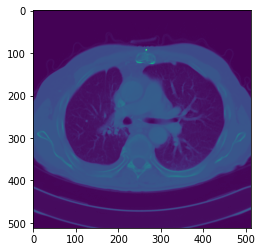

In [39]:
import pydicom as dicom
import matplotlib.pylab as plt
# specify your image path
image_path = '/content/drive/MyDrive/Data/dicom_dir/ID_0001_AGE_0069_CONTRAST_1_CT.dcm'
ds = dicom.dcmread(image_path)
test1 = ds.pixel_array
plt.imshow(test1)

In [40]:
from skimage.transform import resize
IMG_PX_SIZE = 128
# resize to new size
resized1 = resize(test1, (IMG_PX_SIZE, IMG_PX_SIZE, 1), anti_aliasing=True)
resized1.shape

(128, 128, 1)

In [41]:
pred1 = model.predict(resized1.reshape(1,128,128,1))

In [42]:
round_prediction1 = np.round(pred1[0])
prediction = str('%.2f' % (pred1[0][1]*100) + '%')
prediction

'91.76%'

91.76% The patient has Cancer disease


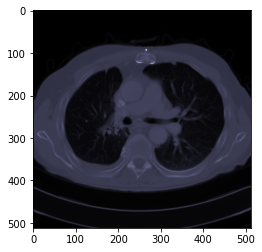

In [43]:
round_prediction1 = np.round(pred1[0])
prob = str('%.2f' % (pred1[0][1]*100) + '%')
if round_prediction1[0] == 1:
    print('Normal Patient')
else:
    print(prob,"The patient has Cancer disease")
plt.imshow(test1, cmap="bone")

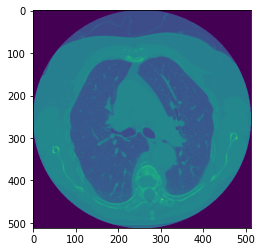

In [44]:
image_path = '/content/drive/MyDrive/Data/dicom_dir/ID_0090_AGE_0067_CONTRAST_0_CT.dcm'
ds = dicom.dcmread(image_path)
test90 = ds.pixel_array
plt.imshow(test90)

In [45]:
IMG_PX_SIZE = 128
# resize to new size
resized90 = resize(test90, (IMG_PX_SIZE, IMG_PX_SIZE, 1), anti_aliasing=True)
resized90.shape

(128, 128, 1)

In [46]:
pred90 = model.predict(resized90.reshape(1,128, 128, 1))

25.34% Normal Patient


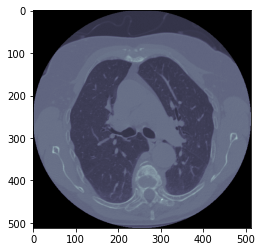

In [47]:
round_prediction90 = np.round(pred90[0])
prob = str('%.2f' % (pred90[0][1]*100) + '%')
if round_prediction90[0] == 1:
    print(prob, 'Normal Patient')
else:
    print(prob,"The patient has Cancer disease ")
plt.imshow(test90, cmap="bone")

81.64% The patient has Cancer disease 


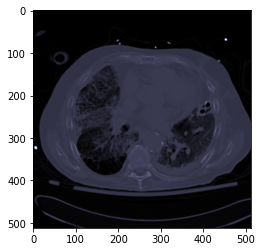

In [48]:
image_path = '/content/drive/MyDrive/Data/dicom_dir/ID_0055_AGE_0071_CONTRAST_0_CT.dcm'
ds = dicom.dcmread(image_path)
test90 = ds.pixel_array
plt.imshow(test90)

IMG_PX_SIZE = 128
# resize to new size
resized90 = resize(test90, (IMG_PX_SIZE, IMG_PX_SIZE, 1), anti_aliasing=True)
resized90.shape

pred90 = model.predict(resized90.reshape(1,128, 128, 1))

round_prediction90 = np.round(pred90[0])
prob = str('%.2f' % (pred90[0][1]*100) + '%')
if round_prediction90[0] == 1:
    print(prob, 'Normal Patient')
else:
    print(prob,"The patient has Cancer disease ")
plt.imshow(test90, cmap="bone")

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
pred = model.predict(input_test)
pred[2]

array([3.5743153e-04, 9.9964261e-01], dtype=float32)

In [51]:
pred = np.round(pred)

In [52]:
y_train = pd.DataFrame(pred)

In [53]:
y_train.pop(0)
y_train[1]

0    1.0
1    1.0
2    1.0
3    0.0
4    0.0
5    0.0
6    1.0
7    0.0
8    0.0
9    0.0
Name: 1, dtype: float32

In [56]:
y_train[1] = pd.to_numeric(y_train[1], errors='coerce', downcast="integer")
type(y_train[1][1])

numpy.int8

In [57]:
y_test[0] = pd.to_numeric(y_test[0], errors='coerce', downcast="integer")
type(y_test[0][1])

numpy.int8

In [58]:
y_train.columns

Int64Index([1], dtype='int64')

In [59]:
y_test.columns = [1]

In [60]:
y_test

,1
0013,1
0077,0
0002,1
0091,0
0087,0
0063,0
0015,1
0056,0
0067,0
0059,0


In [61]:
cm=confusion_matrix(y_test,y_train)

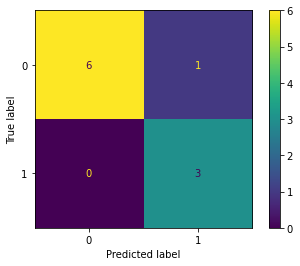

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [63]:
f1_score(y_test, y_train)

0.8571428571428571